# Βιβλιοθήκες

In [1]:
import numpy as np
import pandas as pd

from sklearn import feature_extraction, model_selection, feature_selection, naive_bayes, pipeline, metrics
from sklearn.metrics import classification_report

import gensim
import gensim.downloader as api
from gensim.models.phrases import Phrases

from tensorflow.keras import models, layers, preprocessing as kprocessing

import transformers

2022-04-10 01:20:39.694613: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-10 01:20:39.694755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Εισαγωγή δεδομένων και επισκόπησή τους

In [2]:
sample_submission_file = "/kaggle/input/eeestech-challenge-task-3/sample_submission.csv"
train_file = "/kaggle/input/eestech-challenge-task-3/train.csv"
test_file = "/kaggle/input/eestech-challenge-task-3/test.csv"

In [3]:
train_data = pd.read_csv(train_file) 
test_data = pd.read_csv(test_file) 
train_data.head()

,pmid,label,abstract,text_clean
0,32716900,Prevention,BACKGROUND: Advance care planning is the proce...,background advance care planning process discu...
1,32464491,Mechanism,Selenium (Se) is a ubiquitous element akin to ...,selenium se ubiquitous element akin sulfur exi...
2,32361001,Mechanism,"During virus infection, host toll-like recepto...",virus infection host tolllike receptor tlrs re...
3,32915888,Prevention,"Globally, little evidence exists on transmissi...",globally little evidence exists transmission p...
4,33004659,Prevention,BACKGROUND: The UK has been one of the Europea...,background uk one european country affected co...


In [4]:
test_data1 = pd.read_csv(test_file) 


In [5]:
train_data.shape

(20587, 4)

Ας δούμε την περίληψη του άρθρου της πρώτης γραμμής που είναι στην κατηγορία "Prevention".

In [6]:
train_data.iloc[0]['abstract']
train_data.iloc[0]['text_clean']

'background advance care planning process discussing health care treatment preference based patient personal value often involves completion advance directive first month 2020 novel coronavirus severe acute respiratory syndrome coronavirus 2 sarscov2 began circulating widely american state colorado leading widespread diagnosis coronavirus disease covid19 hospitalization death context importance technologybased nonfacetoface method conduct advance care planning via patient portal increased objective aim study determine rate use webbased advance care planning tool health systembased electronic patient portal early month covid19 pandemic method 2017 implemented webbased tool patient portal uchealths electronic health record ehr patient learn advance care planning complete electronically signed medical durable power attorney mdpoa legally appoint medical decision maker patient accessing portal complete submit legally valid mdpoa becomes part medical record collected data patient date mdpoa

Πράγματι, μιλάει για "Advance care planning" κοκ. Ας κάνουμε και μια άλλη δοκιμή:

In [7]:
print(train_data.iloc[100]['abstract'])
print(train_data.iloc[100]['label'])

This work presents the modeling and prediction of cases of COVID-19 infection in Mexico through mathematical and computational models using only the confirmed cases provided by the daily technical report COVID-19 MEXICO until May 8(th). The mathematical models: Gompertz and Logistic, as well as the computational model: Artificial Neural Network were applied to carry out the modeling of the number of cases of COVID-19 infection from February 27(th) to May 8(th). The results show a good fit between the observed data and those obtained by the Gompertz, Logistic and Artificial Neural Networks models with an R(2) of 0.9998, 0.9996, 0.9999, respectively. The same mathematical models and inverse Artificial Neural Network were applied to predict the number of cases of COVID-19 infection from May 9(th) to 16(th) in order to analyze tendencies and extrapolate the projection until the end of the epidemic. The Gompertz model predicts a total of 47,576 cases, the Logistic model a total of 42,131 ca

In [8]:
test_data.head()

,pmid,abstract,text_clean
0,32355107,Coronavirus disease (COVID-19) is responsible ...,coronavirus disease covid19 responsible global...
1,32606823,The outbreak of coronavirus disease 2019 (COVI...,outbreak coronavirus disease 2019 covid19 pand...
2,32931811,OBJECTIVE: To describe the implementation and ...,objective describe implementation result proac...
3,32311451,The coronavirus disease 2019 (COVID-19) was fi...,coronavirus disease 2019 covid19 first reporte...
4,32395672,As the coronavirus disease 2019 pandemic sprea...,coronavirus disease 2019 pandemic spread aroun...


In [9]:
test_data.shape

(6862, 3)

In [10]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(train_data, test_size=0.3)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values
n_categories = len(np.unique(y_train))

# Bag-of-Words
Η παραδοσιακή μέθοδος NLP μετατροπής κειμένων σε διανύσματα.

In [11]:
#train_data=train_data.dropna()

In [12]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [13]:


# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)



2022-04-10 01:20:47.229422: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-10 01:20:47.232397: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-10 01:20:47.232440: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-10 01:20:47.232468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (99177c630669): /proc/driver/nvidia/version does not exist
2022-04-10 01:20:47.235691: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [14]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [15]:
X_data = train_data[['text_clean']].to_numpy().reshape(-1)
y_data = train_data[['label']].to_numpy().reshape(-1)

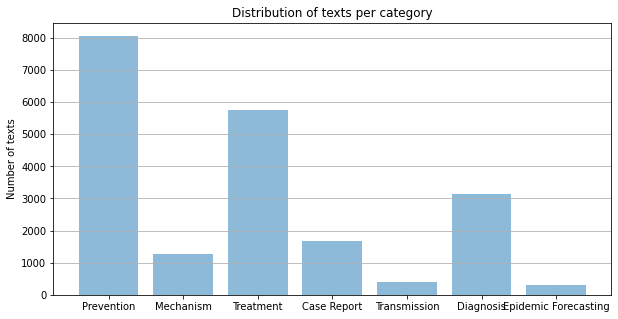

Counter({'Prevention': 8059, 'Treatment': 5740, 'Diagnosis': 3135, 'Case Report': 1686, 'Mechanism': 1269, 'Transmission': 395, 'Epidemic Forecasting': 303})


In [16]:
categories = train_data[['label']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)



In [17]:
def calculate_stats(df, split_char=' '):
    categories = train_data['label'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in train_data.iterrows():
        text = row['text_clean']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['label']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    categories = train_data['label'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [18]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(str(text))
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [19]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c
    
    y_data[index] = category_id

# Display dictionary
category_to_name
mapping = {'Case Report': 0, 'Diagnosis': 1, 'Epidemic Forecasting': 2, 'Mechanism': 3, 'Prevention': 4, 'Transmission': 5, 'Treatment': 6}

{0: 'Prevention',
 1: 'Mechanism',
 2: 'Treatment',
 3: 'Case Report',
 4: 'Transmission',
 5: 'Diagnosis',
 6: 'Epidemic Forecasting'}

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [21]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [23]:
X_train

{'input_word_ids': array([[    0, 25064,   892, ...,     1,     1,     1],
        [    0,  7215,   261, ...,     1,     1,     1],
        [    0,   119, 13161, ...,     1,     1,     1],
        ...,
        [    0,  8331,   449, ...,     1,     1,     1],
        [    0, 40412,  2088, ...,     1,     1,     1],
        [    0,   438,  1417, ...,     1,     1,     1]], dtype=int32),
 'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 'input_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}

In [24]:
y_train

array([5, 3, 0, ..., 4, 0, 0], dtype=int32)

In [25]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [26]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [27]:


with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=5,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))



Training...
Epoch 1/5
226/226 [==============================] - 151s 357ms/step - loss: 0.9014 - accuracy: 0.6689 - val_loss: 0.5387 - val_accuracy: 0.8018
Epoch 2/5
226/226 [==============================] - 26s 116ms/step - loss: 0.4468 - accuracy: 0.8314 - val_loss: 0.5296 - val_accuracy: 0.8086
Epoch 3/5
226/226 [==============================] - 26s 116ms/step - loss: 0.3031 - accuracy: 0.8895 - val_loss: 0.5923 - val_accuracy: 0.7984
Epoch 4/5
226/226 [==============================] - 26s 116ms/step - loss: 0.1434 - accuracy: 0.9538 - val_loss: 0.6646 - val_accuracy: 0.7918
Epoch 5/5
226/226 [==============================] - 26s 115ms/step - loss: 0.0623 - accuracy: 0.9829 - val_loss: 0.7383 - val_accuracy: 0.7972


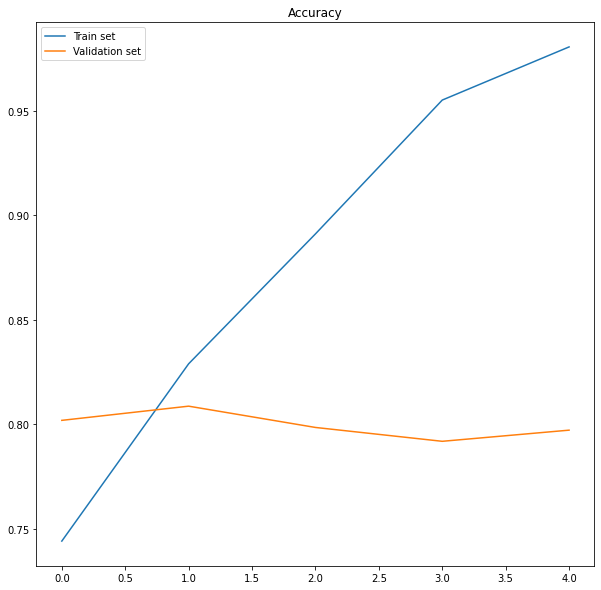

In [28]:


# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()



In [29]:
#validation
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
test_data = test_data[['text_clean']].to_numpy().reshape(-1)

#X_test

In [31]:
test_to = roberta_encode(test_data, tokenizer)


In [32]:

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))
print(scores)

Accuracy: 79.67%
[0.7385224103927612, 0.7966650724411011]


In [33]:
final_predictions = model.predict(test_to)
final_predictions = [np.argmax(i) for i in model.predict(test_to)]

## Ένας απλός ταξινομητής

## Πρόβλεψη
Στα test data πλέον.

# Υποβολή

In [52]:
final_predictions = [np.argmax(i) for i in model.predict(test_to)]
df_final_predictions = pd.DataFrame(final_predictions)
df_final_predictions.columns=['label']
df_ids = test_data1[["pmid"]].copy()
submission_concat = pd.concat([df_ids, df_final_predictions], axis=1)
#print(category_to_name)
#print(submission_concat)
mapping = category_to_name
submission_df=submission_concat.replace({"label": mapping})
#print(submission_df)
mapping1 = {'Case Report': 0, 'Diagnosis': 1, 'Epidemic Forecasting': 2, 'Mechanism': 3, 'Prevention': 4, 'Transmission': 5, 'Treatment': 6}
submission_df1=submission_df.replace({"label": mapping1})

#mapping1 = {0:'Case Report',  1:'Diagnosis', 2:'Epidemic Forecasting': , 'Mechanism': 3, 'Prevention': 4, 'Transmission': 5, 'Treatment': 6}
#submission_df=submission_concat.replace({"label": mapping1})
#print(submission_df1)
submission_df1.to_csv('submission.csv', index=False)

In [46]:
submission_df

,pmid,label
0,32355107,Prevention
1,32606823,Treatment
2,32931811,Prevention
3,32311451,Mechanism
4,32395672,Prevention
...,...,...
6857,34226887,Prevention
6858,34216472,Treatment
6859,32826763,Prevention
6860,32793973,Prevention


In [41]:
category_to_name

{0: 'Prevention',
 1: 'Mechanism',
 2: 'Treatment',
 3: 'Case Report',
 4: 'Transmission',
 5: 'Diagnosis',
 6: 'Epidemic Forecasting'}